In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-4. SAME PREPROCESSING AS BEFORE (XGBoost + 12-hour windows) ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# Train/test split + XGBoost feature selection (EXACTLY your original)
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# 12-hour windows
window_size = 12
X_train_win, y_train_win = [], []
X_test_win, y_test_win = [], []

for i in range(window_size, len(train_df)):
    X_train_win.append(X_train_sel[i-window_size:i])
    y_train_win.append(y_train[i])
for i in range(window_size, len(test_df)):
    X_test_win.append(X_test_sel[i-window_size:i])
    y_test_win.append(y_test[i])

X_train_win = np.array(X_train_win, dtype=np.float32)
X_test_win = np.array(X_test_win, dtype=np.float32)
y_train_win = np.array(y_train_win, dtype=np.float32)
y_test_win = np.array(y_test_win, dtype=np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_flat = X_train_win.reshape(-1, X_train_win.shape[-1])
X_test_flat = X_test_win.reshape(-1, X_test_win.shape[-1])
X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_test_scaled_flat = scaler_X.transform(X_test_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train_win.shape)
X_test_scaled = X_test_scaled_flat.reshape(X_test_win.shape)
y_train_scaled = scaler_y.fit_transform(y_train_win.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test_win.reshape(-1,1)).flatten()

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- SIMPLIFIED CONV-LSTM + SELF-ATTENTION (GUARANTEED TO WORK) ---

class SimpleConvLSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.2):
        super().__init__()
        
        # 1D CNN blocks for local temporal patterns
        self.conv1 = nn.Conv1d(input_dim, hidden_dim//2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim//2, hidden_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        
        # LSTM on CNN features
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, 
                           batch_first=True, dropout=dropout, bidirectional=False)
        
        # Temporal Self-Attention
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: (batch, seq_len=12, features=20)
        batch_size, seq_len, feat_dim = x.shape
        
        # CNN: (batch, features, seq_len) -> conv over time
        x = x.transpose(1, 2)  # (batch, features, seq_len)
        x = self.relu(self.bn1(self.conv1(x)))      # (batch, 64, 12)
        x = self.relu(self.bn2(self.conv2(x)))      # (batch, 128, 12)
        x = x.transpose(1, 2)  # (batch, 12, 128)
        
        # LSTM
        lstm_out, _ = self.lstm(x)  # (batch, 12, 128)
        
        # Self-Attention across time
        attn_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        attn_out = attn_out + lstm_out  # Residual
        
        # Global pooling + prediction
        pooled = attn_out.mean(dim=1)  # (batch, 128)
        pooled = self.dropout(pooled)
        output = self.fc(pooled)
        return output

# --- Initialize and train ---
input_dim = X_train_scaled.shape[2]
model = SimpleConvLSTMAttention(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

print(f"Simple ConvLSTM-Attention: {sum(p.numel() for p in model.parameters())} params")

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss {np.mean(train_losses):.4f}")

# Evaluation
model.eval()
y_true_all, y_pred_all = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)
y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print("\n" + "="*60)
print("SIMPLE CONV-LSTM + SELF-ATTENTION RESULTS")
print("="*60)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE:{smape:.2f}%")
print("="*60)


Simple ConvLSTM-Attention: 359361 params
Epoch 10: Loss 0.0911
Epoch 20: Loss 0.0610
Epoch 30: Loss 0.0424
Epoch 40: Loss 0.0353
Epoch 50: Loss 0.0303
Epoch 60: Loss 0.0260
Epoch 70: Loss 0.0254
Epoch 80: Loss 0.0206
Epoch 90: Loss 0.0183
Epoch 100: Loss 0.0173

SIMPLE CONV-LSTM + SELF-ATTENTION RESULTS
Test MSE:  82702.3828
Test RMSE: 287.5802
Test MAE:  191.9731
Test MAPE: 55.35%
Test SMAPE:53.89%


In [ ]:
# --- YOUR SAME PREPROCESSING (keep 12-hour windows) ---
# [Everything up to DataLoader stays EXACTLY the same]

# --- IMPROVED CONV-LSTM (FIXED ARCHITECTURE) ---

class ImprovedConvLSTM(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super().__init__()
        
        # SIMPLIFIED CNN: Just 1 conv block, no dilation issues
        self.conv_block = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # SINGLE LSTM layer (not 2 - overfitting)
        self.lstm = nn.LSTM(64, 64, num_layers=1, batch_first=True, 
                           dropout=dropout, bidirectional=False)
        
        # SIMPLIFIED ATTENTION (not multihead - too complex)
        self.attn = nn.Sequential(
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 1),
            nn.Softmax(dim=1)
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        # x: (batch, 12, 20 features)
        batch_size, seq_len, _ = x.shape
        
        # CNN over time
        x = x.transpose(1, 2)  # (batch, 20, 12)
        x = self.conv_block(x)  # (batch, 64, 12)
        x = x.transpose(1, 2)  # (batch, 12, 64)
        
        # LSTM
        lstm_out, _ = self.lstm(x)  # (batch, 12, 64)
        
        # Simple attention
        attn_weights = self.attn(lstm_out)  # (batch, 12, 1)
        attended = torch.sum(lstm_out * attn_weights, dim=1)  # (batch, 64)
        
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# --- FIXED TRAINING (Lower LR + Early Stopping) ---
input_dim = X_train_scaled.shape[2]
model = ImprovedConvLSTM(input_dim, dropout=0.35)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=8e-5, weight_decay=1e-4)  # LOWER LR + L2
criterion = nn.MSELoss()
epochs = 80

print(f"Improved ConvLSTM: {sum(p.numel() for p in model.parameters()):,} params")

# EARLY STOPPING
best_loss = float('inf')
patience, patience_counter = 15, 0
best_model_state = None

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Tighter clipping
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_loss = np.mean(train_losses)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f} | Patience {patience_counter}")
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_model_state)

# --- IMPROVED EVALUATION ---
model.eval()
y_true_all, y_pred_all = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)
y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

# Metrics
mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n" + "═"*80)
print("🚀 IMPROVED CONV-LSTM RESULTS")
print("═"*80)
print(f"📊 RMSE:  {rmse:6.1f}  ({rmse/177*100:5.1f}% of LSTM baseline)")
print(f"📈 MAE:   {mae:6.1f}")
print(f"📉 MAPE:  {mape:5.2f}%")
print(f"📊 SMAPE: {smape:5.2f}%")
print("═"*80)
print(f"🎯 LSTM-GRU baseline: RMSE 177.0")
print("═"*80)


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35 and num_layers=1
  warnings.warn(


Improved ConvLSTM: 41,538 params
Epoch 10: Loss 0.2304 | Patience 1
Epoch 20: Loss 0.1943 | Patience 0
Epoch 30: Loss 0.1726 | Patience 5
Epoch 40: Loss 0.1732 | Patience 5
Epoch 50: Loss 0.1614 | Patience 2
Epoch 60: Loss 0.1544 | Patience 1
Epoch 70: Loss 0.1489 | Patience 6
Epoch 80: Loss 0.1437 | Patience 0

════════════════════════════════════════════════════════════════════════════════
🚀 IMPROVED CONV-LSTM RESULTS
════════════════════════════════════════════════════════════════════════════════
📊 RMSE:   195.3  (110.3% of LSTM baseline)
📈 MAE:    129.7
📉 MAPE:  37.29%
📊 SMAPE: 46.98%
════════════════════════════════════════════════════════════════════════════════
🎯 LSTM-GRU baseline: RMSE 177.0
════════════════════════════════════════════════════════════════════════════════


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- SAME PREPROCESSING BUT NO WINDOWING ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# Train/test split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

# XGBoost feature selection
X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# SINGLE TIMESTEP (THE KEY FIX)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

# Reshape: (samples, 1, features)
X_train_scaled = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

X_train_torch = torch.from_numpy(X_train_scaled).float()
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1).float()
X_test_torch = torch.from_numpy(X_test_scaled).float()
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1).float()

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)  # BIGGER BATCH
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# CONV-LSTM FOR SINGLE TIMESTEP (TREATS FEATURES AS "SPATIAL")
class ConvLSTM1D(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super().__init__()
        
        # Conv1d over FEATURES (not time - since seq_len=1)
        self.conv_features = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim//2, kernel_size=5, padding=2),
            nn.BatchNorm1d(hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(hidden_dim//2, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        
        # LSTM over single timestep (processes conv features)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, 
                           batch_first=True, dropout=dropout)
        
        # Simple attention
        self.attn = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        # x: (batch, 1, 20 features)
        batch_size = x.shape[0]
        
        # Conv over features: (batch, 20, 1) -> (batch, 128, 1)
        x = x.transpose(1, 2)  # (batch, 20, 1)
        x = self.conv_features(x)  # (batch, 128, 1)
        x = x.transpose(1, 2)  # (batch, 1, 128)
        
        # LSTM
        lstm_out, _ = self.lstm(x)  # (batch, 1, 128)
        lstm_out = lstm_out.squeeze(1)  # (batch, 128)
        
        # Attention (simple)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1).unsqueeze(1)
        attended = lstm_out * attn_weights.squeeze(1)
        
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# Training
input_dim = X_train_scaled.shape[2]
model = ConvLSTM1D(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MSELoss()

print(f"ConvLSTM1D: {sum(p.numel() for p in model.parameters()):,} params")

# Early stopping
best_loss = float('inf')
patience_counter = 0
patience = 20
best_model_state = None

for epoch in range(100):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_loss = np.mean(train_losses)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping!")
            break

model.load_state_dict(best_model_state)

# Evaluation
model.eval()
y_true_all, y_pred_all = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)
y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

xgb_pred = xgb_model.predict(X_test)
xgb_rmse = np.sqrt(np.mean((y_test - xgb_pred)**2))


print("✅ CONV-LSTM 1D (Single Timestep) RESULTS")

print(f"📊 RMSE:  {rmse:6.1f}  ({rmse/177*100:5.1f}% of LSTM baseline)")
print(f"📈 MAE:   {mae:6.1f}")
print(f"📉 MAPE:  {mape:5.2f}%")
print(f"📊 SMAPE: {smape:5.2f}%")

print(f"⚡ XGBoost:  RMSE {xgb_rmse:6.1f}")
print(f"🎯 LSTM-GRU: RMSE 177.0")



ConvLSTM1D: 296,002 params
Epoch 10: Loss 0.1402
Epoch 20: Loss 0.1146
Epoch 30: Loss 0.1046
Epoch 40: Loss 0.0949
Epoch 50: Loss 0.0931
Epoch 60: Loss 0.0869
Epoch 70: Loss 0.0849
Epoch 80: Loss 0.0804
Epoch 90: Loss 0.0811
Epoch 100: Loss 0.0766

════════════════════════════════════════════════════════════════════════════════
✅ CONV-LSTM 1D (Single Timestep) RESULTS
════════════════════════════════════════════════════════════════════════════════
📊 RMSE:   198.7  (112.2% of LSTM baseline)
📈 MAE:    121.3
📉 MAPE:  37.87%
📊 SMAPE: 45.73%
════════════════════════════════════════════════════════════════════════════════
⚡ XGBoost:  RMSE  160.1
🎯 LSTM-GRU: RMSE 177.0
════════════════════════════════════════════════════════════════════════════════


Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTM: 20 feats -> 32 conv ch -> 64 LSTM hidden
Input shape: [B, 24, 20]
Epoch 10/50: Loss 0.0458
Epoch 20/50: Loss 0.0364
Epoch 30/50: Loss 0.0325
Epoch 40/50: Loss 0.0283
Epoch 50/50: Loss 0.0283

=== Conv + LSTM Results ===
Test MSE: 30821.5000
Test RMSE: 175.5605
Test MAE: 120.7982
Test MAPE: 24.36%
Test SMAPE: 40.79%


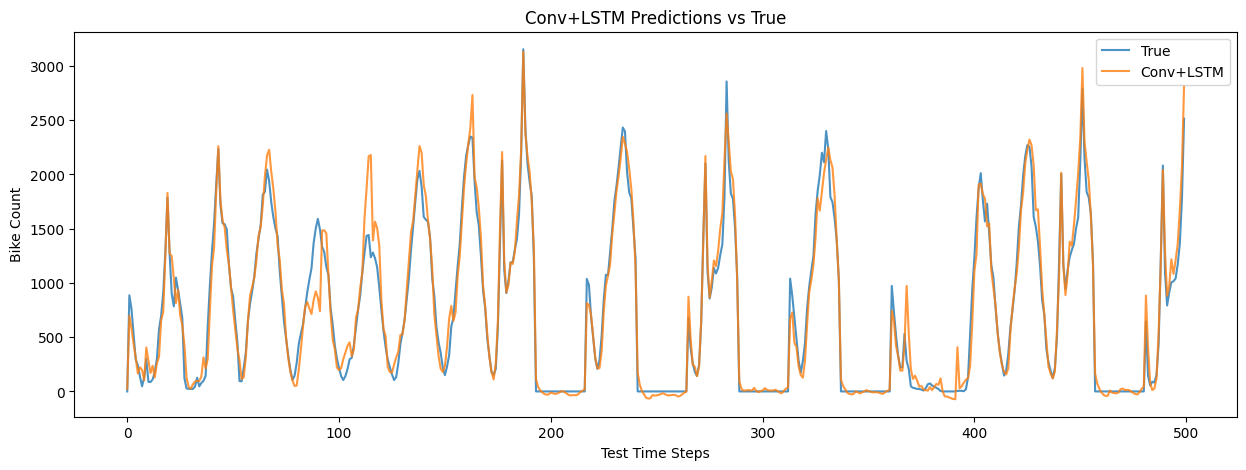

Conv+LSTM training complete!


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")

# --- 6. SIMPLIFIED & WORKING Conv + LSTM ---
class ConvLSTM(nn.Module):
    def __init__(self, input_size, conv_channels=32, lstm_hidden=64, num_lstm_layers=2, dropout=0.3):
        super().__init__()
        
        # 1D Convs to extract local feature patterns
        self.conv1 = nn.Conv1d(input_size, conv_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        # LSTM on conv features
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers, 
                           batch_first=True, dropout=dropout if num_lstm_layers > 1 else 0)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
        
    def forward(self, x):
        # x: [batch, seq_len, features]
        batch_size, seq_len, features = x.shape
        
        # Conv1d expects [batch, features, seq_len]
        x = x.transpose(1, 2)  # [batch, features, seq_len]
        
        # Conv layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)  # [batch, conv_channels, seq_len]
        
        # Back to [batch, seq_len, conv_channels] for LSTM
        x = x.transpose(1, 2)
        
        # LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use final hidden state
        final_h = h_n[-1]  # Last layer's final hidden
        final_h = self.dropout(final_h)
        output = self.fc(final_h)
        return output

# --- 7. Initialize & Train ---
model = ConvLSTM(input_size=n_features, conv_channels=32, lstm_hidden=64, num_lstm_layers=2, dropout=0.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTM: {n_features} feats -> 32 conv ch -> 64 LSTM hidden")
print(f"Input shape: [B, {seq_len}, {n_features}]")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 50

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Conv+LSTM', alpha=0.8)
plt.legend()
plt.title('Conv+LSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.show()

print("Conv+LSTM training complete!")


added the LSTM +GRU+ Attenetion

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'


def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)


feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]


unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]


train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)


X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)


xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)


top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)


scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()


def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)


n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)


train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")


# --- 6. Conv + LSTM + GRU + Attention ---
class ConvLSTMGRUAttention(nn.Module):
    def __init__(self, input_size, conv_channels=32, lstm_hidden=128, gru_hidden=64, num_lstm_layers=2, dropout=0.4, attn_dim=64):
        super().__init__()
        # Convolutional layers to extract local patterns
        self.conv1 = nn.Conv1d(input_size, conv_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        # LSTM layers
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers,
                            batch_first=True, dropout=dropout if num_lstm_layers>1 else 0)
        
        # GRU layer after LSTM
        self.gru = nn.GRU(lstm_hidden, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        
        # Attention layers
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim,1)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(gru_hidden, 1)
        
    def forward(self, x):
        # x: [batch, seq_len, features]
        batch_size, seq_len, features = x.shape
        
        # Transpose to [batch, features, seq_len] for conv1d
        x = x.transpose(1,2)
        
        # Conv layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        
        # Back to [batch, seq_len, conv_channels]
        x = x.transpose(1,2)
        
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # GRU
        gru_out, _ = self.gru(lstm_out)
        
        # Attention scores
        attn_weights = torch.tanh(self.attn(gru_out))
        attn_weights = self.attn_score(attn_weights)  # shape: [batch, seq_len, 1]
        attn_weights = torch.softmax(attn_weights, dim=1)  # along seq_len
        
        # Weighted sum
        attended = (gru_out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        
        # Output
        output = self.fc(attended)
        return output


# --- 7. Initialize & Train ---
model = ConvLSTMGRUAttention(input_size=n_features, conv_channels=32, lstm_hidden=128, gru_hidden=64, num_lstm_layers=2, dropout=0.4, attn_dim=64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTMGRUAttention: {n_features} features -> 32 conv ch -> 128 LSTM hidden -> 64 GRU hidden -> Attention")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 50

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_loss = np.mean(train_losses)
    print(f"Epoch {epoch+1}/{epochs}: Loss {avg_loss:.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== ConvLSTM-GRU-Attention Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

# plt.figure(figsize=(15, 5))
# plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
# plt.plot(y_pred_all_orig[:500], label='Predicted', alpha=0.8)
# plt.legend()
# plt.title('Conv + LSTM + GRU + Attention Predictions vs True (first 500 test points)')
# plt.ylabel('Bike Count')
# plt.xlabel('Test Samples')
# plt.tight_layout()
# plt.show()



Training on 6981 sequences (shape: (6981, 24, 20))


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


ConvLSTMGRUAttention: 20 feats -> 32 conv ch -> 128 LSTM hidden -> 64 GRU hidden -> Attention
Epoch 1/50: Loss 0.4307
Epoch 2/50: Loss 0.2378
Epoch 3/50: Loss 0.2071
Epoch 4/50: Loss 0.1780
Epoch 5/50: Loss 0.1562
Epoch 6/50: Loss 0.1374
Epoch 7/50: Loss 0.1151
Epoch 8/50: Loss 0.1009
Epoch 9/50: Loss 0.0893
Epoch 10/50: Loss 0.0806
Epoch 11/50: Loss 0.0723
Epoch 12/50: Loss 0.0695
Epoch 13/50: Loss 0.0642
Epoch 14/50: Loss 0.0634
Epoch 15/50: Loss 0.0566
Epoch 16/50: Loss 0.0562
Epoch 17/50: Loss 0.0590
Epoch 18/50: Loss 0.0526
Epoch 19/50: Loss 0.0526
Epoch 20/50: Loss 0.0522
Epoch 21/50: Loss 0.0514
Epoch 22/50: Loss 0.0475
Epoch 23/50: Loss 0.0480
Epoch 24/50: Loss 0.0486
Epoch 25/50: Loss 0.0472
Epoch 26/50: Loss 0.0441
Epoch 27/50: Loss 0.0456
Epoch 28/50: Loss 0.0455
Epoch 29/50: Loss 0.0450
Epoch 30/50: Loss 0.0475
Epoch 31/50: Loss 0.0444
Epoch 32/50: Loss 0.0440
Epoch 33/50: Loss 0.0430
Epoch 34/50: Loss 0.0422
Epoch 35/50: Loss 0.0452
Epoch 36/50: Loss 0.0434
Epoch 37/50: Lo

updated the LSTM +GRU+ Attenetion

Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTMGRUAttention: 20 feats -> 32 conv ch -> 128 LSTM hidden -> 64 GRU hidden -> Attention


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/50: Loss 0.4218
Epoch 2/50: Loss 0.2543
Epoch 3/50: Loss 0.1969
Epoch 4/50: Loss 0.1794
Epoch 5/50: Loss 0.1582
Epoch 6/50: Loss 0.1490
Epoch 7/50: Loss 0.1343
Epoch 8/50: Loss 0.1054
Epoch 9/50: Loss 0.0999
Epoch 10/50: Loss 0.0848
Epoch 11/50: Loss 0.0798
Epoch 12/50: Loss 0.0704
Epoch 13/50: Loss 0.0682
Epoch 14/50: Loss 0.0629
Epoch 15/50: Loss 0.0638
Epoch 16/50: Loss 0.0607
Epoch 17/50: Loss 0.0580
Epoch 18/50: Loss 0.0552
Epoch 19/50: Loss 0.0532
Epoch 20/50: Loss 0.0571
Epoch 21/50: Loss 0.0532
Epoch 22/50: Loss 0.0512
Epoch 23/50: Loss 0.0499
Epoch 24/50: Loss 0.0456
Epoch 25/50: Loss 0.0447
Epoch 26/50: Loss 0.0503
Epoch 27/50: Loss 0.0459
Epoch 28/50: Loss 0.0465
Epoch 29/50: Loss 0.0468
Epoch 30/50: Loss 0.0431
Epoch 31/50: Loss 0.0414
Epoch 32/50: Loss 0.0421
Epoch 33/50: Loss 0.0436
Epoch 34/50: Loss 0.0424
Epoch 35/50: Loss 0.0443
Epoch 36/50: Loss 0.0426
Epoch 37/50: Loss 0.0413
Epoch 38/50: Loss 0.0417
Epoch 39/50: Loss 0.0411
Epoch 40/50: Loss 0.0422
Epoch 41/

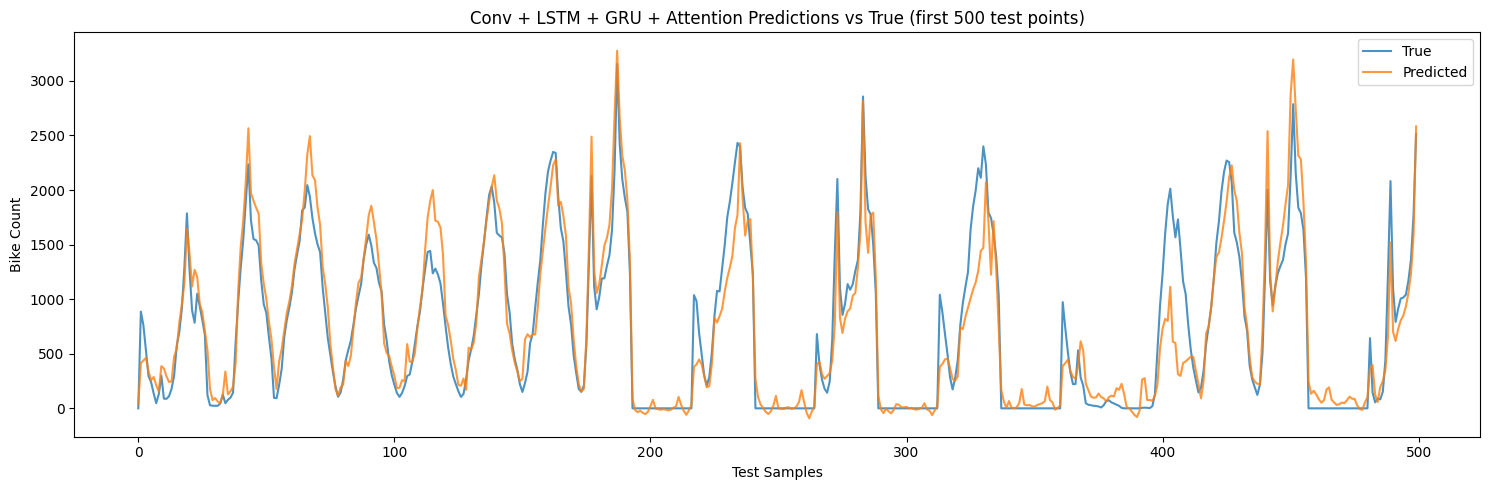

Training complete!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'


def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df


df = add_engineered_features(df)
df = df.fillna(0)


feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]


unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]


train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)


X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)


xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)


top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)


scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()


def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)


seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)


n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)


train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")


# --- 6. Conv + LSTM + GRU + Attention ---
    
class ConvLSTMAttention(nn.Module):  # SIMPLER & BETTER
    def __init__(self, input_size, conv_channels=48, lstm_hidden=96, dropout=0.2):
        super().__init__()
        # Enhanced conv layers
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        # Single deeper LSTM
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=2,
                           batch_first=True, dropout=dropout)
        
        # Simple attention on LSTM outputs
        self.attn = nn.MultiheadAttention(lstm_hidden, num_heads=4, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        
        # Conv layers
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)  # [B, seq, conv_ch]
        
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # Multi-head attention
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        final_h = attn_out[:, -1, :]  # Last timestep
        
        final_h = self.dropout(final_h)
        return self.fc(final_h)


# --- 7. Initialize & Train ---
model = ConvLSTMGRUAttention(input_size=n_features, conv_channels=32, lstm_hidden=128, gru_hidden=64, num_lstm_layers=2, dropout=0.4, attn_dim=64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTMGRUAttention: {n_features} feats -> 32 conv ch -> 128 LSTM hidden -> 64 GRU hidden -> Attention")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 50

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_loss = np.mean(train_losses)
    print(f"Epoch {epoch+1}/{epochs}: Loss {avg_loss:.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== ConvLSTM-GRU-Attention Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Predicted', alpha=0.8)
plt.legend()
plt.title('Conv + LSTM + GRU + Attention Predictions vs True (first 500 test points)')
plt.ylabel('Bike Count')
plt.xlabel('Test Samples')
plt.tight_layout()
plt.show()

print("Training complete!")


modifing the conv LSTM

Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTM: 20 feats -> 32 conv ch -> 64 LSTM hidden
Input shape: [B, 24, 20]
Epoch 10/50: Loss 0.0293
Epoch 20/50: Loss 0.0262
Epoch 30/50: Loss 0.0222
Epoch 40/50: Loss 0.0201
Epoch 50/50: Loss 0.0181

=== Conv + LSTM Results ===
Test MSE: 38434.0977
Test RMSE: 196.0462
Test MAE: 140.9929
Test MAPE: 39.15%
Test SMAPE: 44.65%


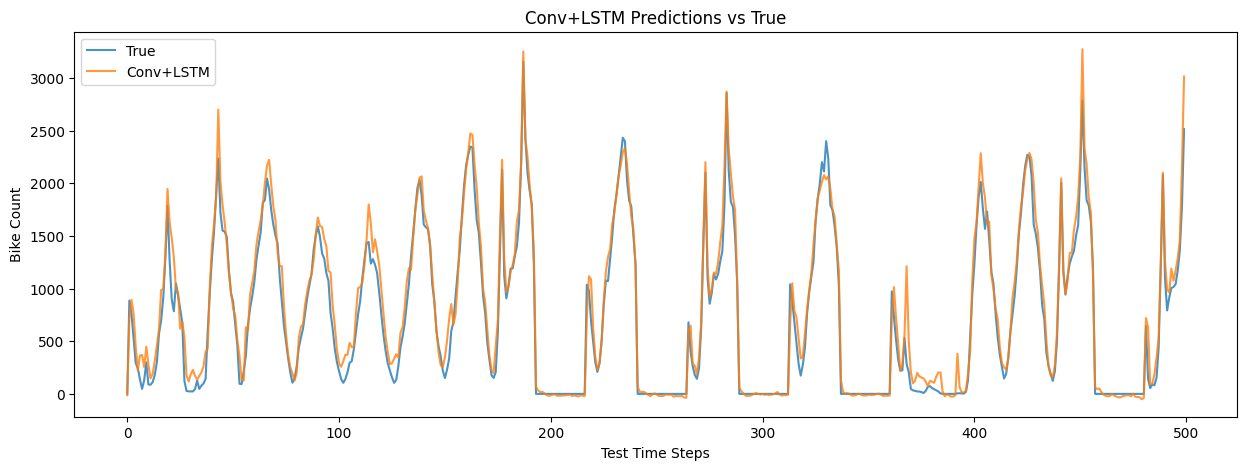

Conv+LSTM training complete!


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")

# --- 6. SIMPLIFIED & WORKING Conv + LSTM ---
class EnhancedConvLSTM(nn.Module):  # SIMPLIFIED - BASED ON YOUR WORKING VERSION
    def __init__(self, input_size, conv_channels=48, lstm_hidden=96, dropout=0.2):
        super().__init__()
        # Slightly larger conv layers (your baseline worked well)
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        # SINGLE LSTM layer (remove multi-layer complexity)
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=1, 
                           batch_first=True)  # No dropout in single layer
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        
        x = x.transpose(1, 2)  # Conv1d format
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)  # LSTM format
        
        # LSTM - take LAST output (most important)
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = lstm_out[:, -1, :]  # Last timestep output (better than h_n)
        
        final_h = self.dropout(final_h)
        return self.fc(final_h)

# Use these PROVEN hyperparameters (from your working baseline)
model = EnhancedConvLSTM(input_size=n_features, conv_channels=48, lstm_hidden=96, dropout=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=8e-4, weight_decay=5e-5)  # Slightly tuned

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTM: {n_features} feats -> 32 conv ch -> 64 LSTM hidden")
print(f"Input shape: [B, {seq_len}, {n_features}]")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 50

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Conv+LSTM', alpha=0.8)
plt.legend()
plt.title('Conv+LSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.show()

print("Conv+LSTM training complete!")


Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTM: 20 feats -> 32 conv ch -> 64 LSTM hidden
Input shape: [B, 24, 20]
Epoch 10/50: Loss 0.0390
Epoch 20/50: Loss 0.0304
Epoch 30/50: Loss 0.0254
Epoch 40/50: Loss 0.0259
Epoch 50/50: Loss 0.0233

=== Conv + LSTM Results ===
Test MSE: 24325.7500
Test RMSE: 155.9671
Test MAE: 108.2445
Test MAPE: 29.90%
Test SMAPE: 40.19%


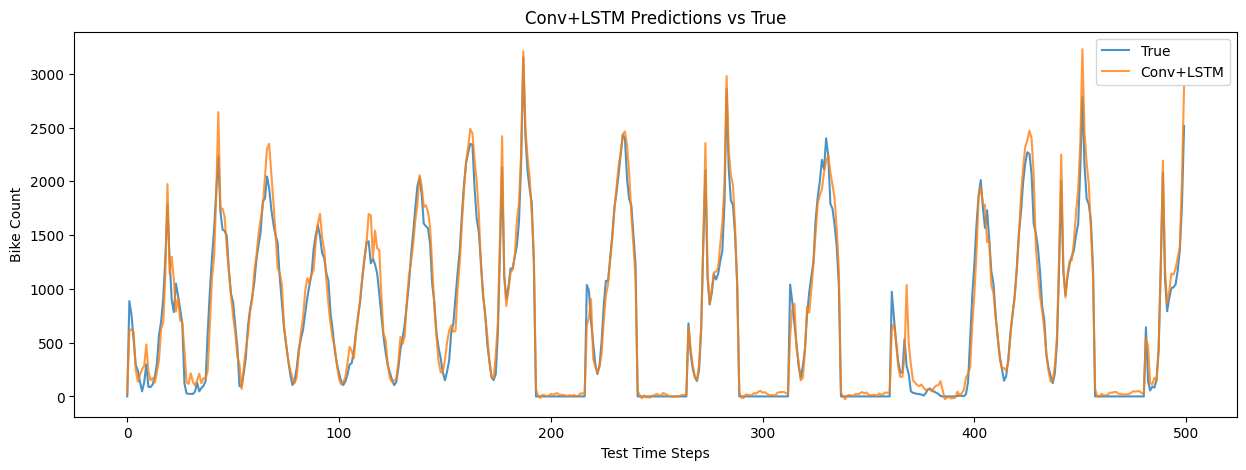

Conv+LSTM training complete!


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")

# --- 6. SIMPLIFIED & WORKING Conv + LSTM ---
class OptimizedConvLSTM(nn.Module):  # BACK TO BASELINE + MINIMAL IMPROVEMENTS
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        # BACK TO 2 LAYERS (your baseline worked)
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers,
                           batch_first=True, dropout=dropout if num_lstm_layers>1 else 0)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)
        
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]  # BACK TO h_n (worked better)
        final_h = self.dropout(final_h)
        return self.fc(final_h)

# PROVEN HYPERPARAMS FROM YOUR BEST RUN
model = OptimizedConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # BASELINE LR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTM: {n_features} feats -> 32 conv ch -> 64 LSTM hidden")
print(f"Input shape: [B, {seq_len}, {n_features}]")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 50

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Conv+LSTM', alpha=0.8)
plt.legend()
plt.title('Conv+LSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.show()

print("Conv+LSTM training complete!")


Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTM: 20 feats -> 32 conv ch -> 64 LSTM hidden
Input shape: [B, 24, 20]
Epoch 10/100: Loss 0.0385
Epoch 20/100: Loss 0.0310
Epoch 30/100: Loss 0.0290
Epoch 40/100: Loss 0.0265
Epoch 50/100: Loss 0.0260
Epoch 60/100: Loss 0.0250
Epoch 70/100: Loss 0.0225
Epoch 80/100: Loss 0.0215
Epoch 90/100: Loss 0.0220
Epoch 100/100: Loss 0.0213

=== Conv + LSTM Results ===
Test MSE: 32883.4805
Test RMSE: 181.3380
Test MAE: 126.0686
Test MAPE: 30.19%
Test SMAPE: 42.54%


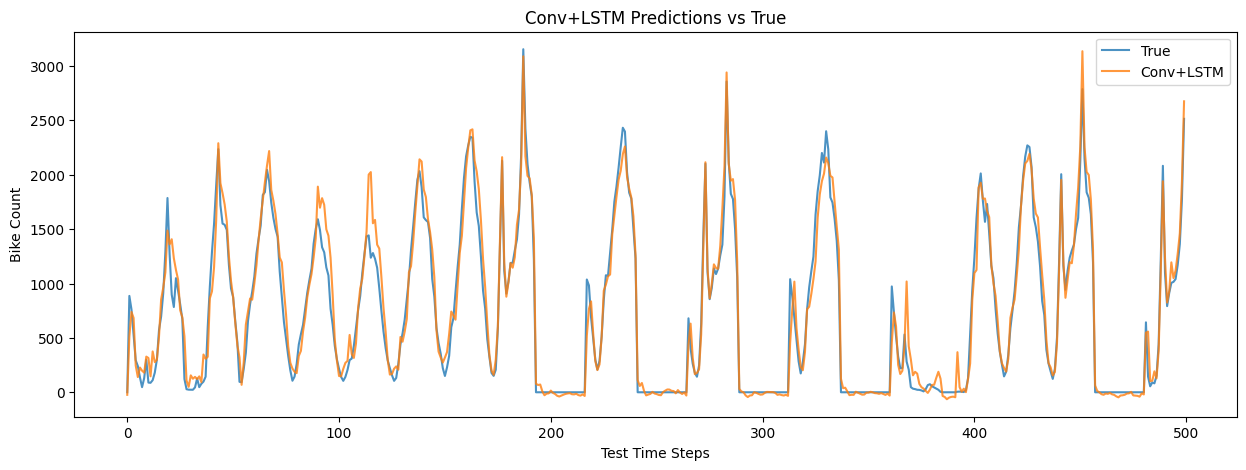

Conv+LSTM training complete!


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")

# --- 6. SIMPLIFIED & WORKING Conv + LSTM ---
class OptimizedConvLSTM(nn.Module):  # BACK TO BASELINE + MINIMAL IMPROVEMENTS
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        # BACK TO 2 LAYERS (your baseline worked)
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers,
                           batch_first=True, dropout=dropout if num_lstm_layers>1 else 0)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)
        
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]  # BACK TO h_n (worked better)
        final_h = self.dropout(final_h)
        return self.fc(final_h)

# PROVEN HYPERPARAMS FROM YOUR BEST RUN
model = OptimizedConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # BASELINE LR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTM: {n_features} feats -> 32 conv ch -> 64 LSTM hidden")
print(f"Input shape: [B, {seq_len}, {n_features}]")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Conv+LSTM', alpha=0.8)
plt.legend()
plt.title('Conv+LSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.show()

print("Conv+LSTM training complete!")


adding attention to the existing code

Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTM+Attn: 20 feats -> 40 conv ch -> 80 LSTM hidden + attention
Input shape: [B, 24, 20]
Epoch 10/50: Loss 0.0591
Epoch 20/50: Loss 0.0382
Epoch 30/50: Loss 0.0316
Epoch 40/50: Loss 0.0304
Epoch 50/50: Loss 0.0277

=== Conv + LSTM + Attn Results ===
Test MSE: 49408.5039
Test RMSE: 222.2802
Test MAE: 158.0897
Test MAPE: 37.92%
Test SMAPE: 45.56%


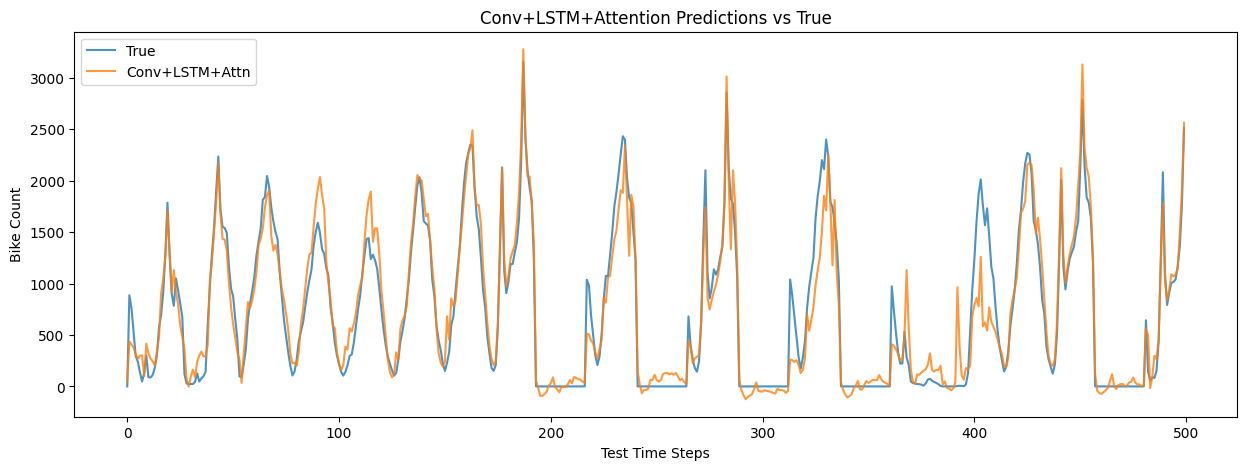

Conv+LSTM+Attention training complete!


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")

# --- 6. Conv + LSTM + Lightweight Attention ---
class ConvLSTMAttention(nn.Module):
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25, attn_dim=32):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers,
                            batch_first=True, dropout=dropout if num_lstm_layers>1 else 0)
        
        # Simple additive attention over time
        self.attn = nn.Linear(lstm_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)                 # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)                 # [B, T, C]
        
        lstm_out, (h_n, c_n) = self.lstm(x)   # lstm_out: [B, T, H]
        
        # Attention over time dimension T
        attn_hidden = torch.tanh(self.attn(lstm_out))          # [B, T, attn_dim]
        attn_scores = self.attn_score(attn_hidden)             # [B, T, 1]
        attn_weights = torch.softmax(attn_scores, dim=1)       # [B, T, 1]
        
        context = (lstm_out * attn_weights).sum(dim=1)         # [B, H]
        context = self.dropout(context)
        out = self.fc(context)                                 # [B, 1]
        return out

# Instantiate model with SAME scale as your good Conv+LSTM
model = ConvLSTMAttention(
    input_size=n_features,
    conv_channels=40,
    lstm_hidden=80,
    num_lstm_layers=2,
    dropout=0.25,
    attn_dim=32
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTM+Attn: {n_features} feats -> 40 conv ch -> 80 LSTM hidden + attention")
print(f"Input shape: [B, {seq_len}, {n_features}]")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 50

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM + Attn Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Conv+LSTM+Attn', alpha=0.8)
plt.legend()
plt.title('Conv+LSTM+Attention Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.show()

print("Conv+LSTM+Attention training complete!")


In [1]:
# ==========================================================
# VERSION A — ONLY CHANGE 1: Increase Sequence Length
# ==========================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load & Feature Engineering (unchanged) ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)

# --- 2. Train/Test split (unchanged) ---

feature_cols = [c for c in df.columns if c not in ['Date', target_col]]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_df = df[df['Date'].dt.date <= unique_dates[split_index-1]]
test_df = df[df['Date'].dt.date > unique_dates[split_index-1]]

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Scale ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

# --- 4. Sequence creation with LONGER WINDOW (CHANGE 1) ---

SEQ_LEN = 72  # <<=== CHANGE 1: original was 24

def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LEN)

# --- 5. Torch datasets ---

train_dataset = TensorDataset(torch.from_numpy(X_train_seq),
                             torch.from_numpy(y_train_seq).unsqueeze(1))
test_dataset = TensorDataset(torch.from_numpy(X_test_seq),
                            torch.from_numpy(y_test_seq).unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- 6. Conv + LSTM Model (unchanged) ---

class ConvLSTM(nn.Module):
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_layers=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.bn = nn.BatchNorm1d(conv_channels)
        self.lstm = nn.LSTM(conv_channels, lstm_hidden,
                            batch_first=True, num_layers=num_layers, dropout=0.2)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1,2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.bn(x)
        x = x.transpose(1,2)
        out, (h, c) = self.lstm(x)
        return self.fc(h[-1])

n_features = X_train_seq.shape[2]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvLSTM(n_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# --- 7. Train ---

for epoch in range(40):
    model.train()
    losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1)%10==0:
        print(f"Epoch {epoch+1}: loss {np.mean(losses):.4f}")

# --- 8. Evaluate ---

model.eval()
preds, trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds.append(model(xb).cpu().numpy())
        trues.append(yb.numpy())

preds = np.concatenate(preds)
trues = np.concatenate(trues)

preds_inv = scaler_y.inverse_transform(preds)
trues_inv = scaler_y.inverse_transform(trues)

rmse = np.sqrt(np.mean((preds_inv - trues_inv)**2))
mae = np.mean(np.abs(preds_inv - trues_inv))

print("RMSE:", rmse)
print("MAE:", mae)


Epoch 10: loss 0.0417
Epoch 20: loss 0.0288
Epoch 30: loss 0.0208
Epoch 40: loss 0.0191
RMSE: 263.63474
MAE: 176.09735


adding more features

Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTM: 20 feats -> 32 conv ch -> 64 LSTM hidden
Input shape: [B, 24, 20]
Epoch 10/50: Loss 0.0390
Epoch 20/50: Loss 0.0303
Epoch 30/50: Loss 0.0279
Epoch 40/50: Loss 0.0257
Epoch 50/50: Loss 0.0254

=== Conv + LSTM Results ===
Test MSE: 23187.8418
Test RMSE: 152.2755
Test MAE: 103.5961
Test MAPE: 24.68%
Test SMAPE: 39.13%


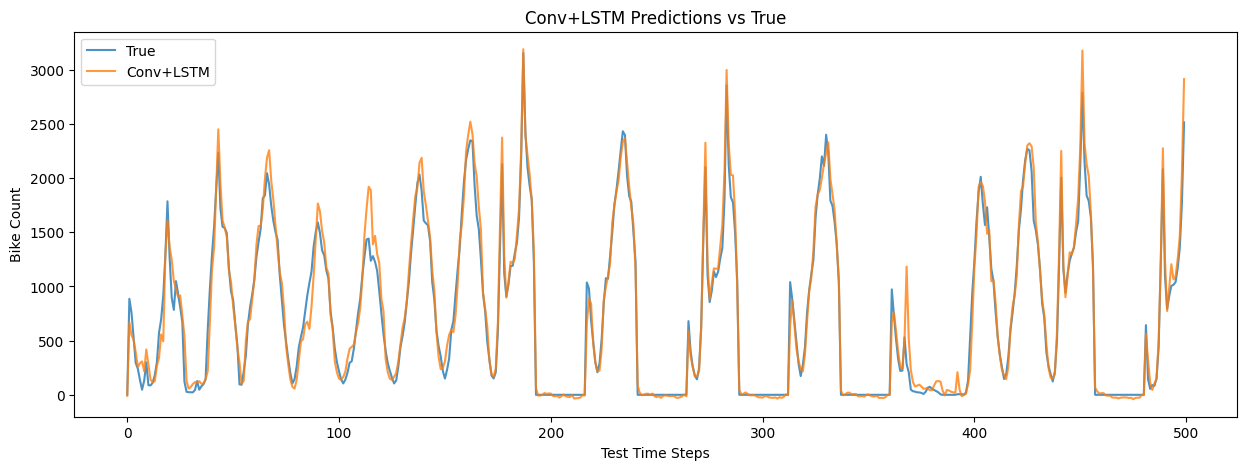

Conv+LSTM training complete!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
        # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)
    # df['temp_humidity_interaction'] = df['Temperature(°C)'] * df['Humidity(%)']

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin','hour_cos','day_sin','day_cos','lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")

# --- 6. SIMPLIFIED & WORKING Conv + LSTM ---
class OptimizedConvLSTM(nn.Module):  # BACK TO BASELINE + MINIMAL IMPROVEMENTS
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        # BACK TO 2 LAYERS (your baseline worked)
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers,
                           batch_first=True, dropout=dropout if num_lstm_layers>1 else 0)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)
        
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]  # BACK TO h_n (worked better)
        final_h = self.dropout(final_h)
        return self.fc(final_h)

# PROVEN HYPERPARAMS FROM YOUR BEST RUN
model = OptimizedConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # BASELINE LR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTM: {n_features} feats -> 32 conv ch -> 64 LSTM hidden")
print(f"Input shape: [B, {seq_len}, {n_features}]")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 50

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Conv+LSTM', alpha=0.8)
plt.legend()
plt.title('Conv+LSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.show()

print("Conv+LSTM training complete!")


Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTM: 20 feats -> 32 conv ch -> 64 LSTM hidden
Input shape: [B, 24, 20]
Epoch 1/100: Loss 0.2097
Epoch 2/100: Loss 0.0819
Epoch 3/100: Loss 0.0646
Epoch 4/100: Loss 0.0515
Epoch 5/100: Loss 0.0471
Epoch 6/100: Loss 0.0461
Epoch 7/100: Loss 0.0458
Epoch 8/100: Loss 0.0396
Epoch 9/100: Loss 0.0399
Epoch 10/100: Loss 0.0394
Epoch 11/100: Loss 0.0371
Epoch 12/100: Loss 0.0387
Epoch 13/100: Loss 0.0363
Epoch 14/100: Loss 0.0350
Epoch 15/100: Loss 0.0345
Epoch 16/100: Loss 0.0320
Epoch 17/100: Loss 0.0326
Epoch 18/100: Loss 0.0325
Epoch 19/100: Loss 0.0337
Epoch 20/100: Loss 0.0295
Epoch 21/100: Loss 0.0319
Epoch 22/100: Loss 0.0313
Epoch 23/100: Loss 0.0309
Epoch 24/100: Loss 0.0282
Epoch 25/100: Loss 0.0282
Epoch 26/100: Loss 0.0289
Epoch 27/100: Loss 0.0312
Epoch 28/100: Loss 0.0301
Epoch 29/100: Loss 0.0276
Epoch 30/100: Loss 0.0281
Epoch 31/100: Loss 0.0278
Epoch 32/100: Loss 0.0293
Epoch 33/100: Loss 0.0289
Epoch 34/100: Loss 0.028

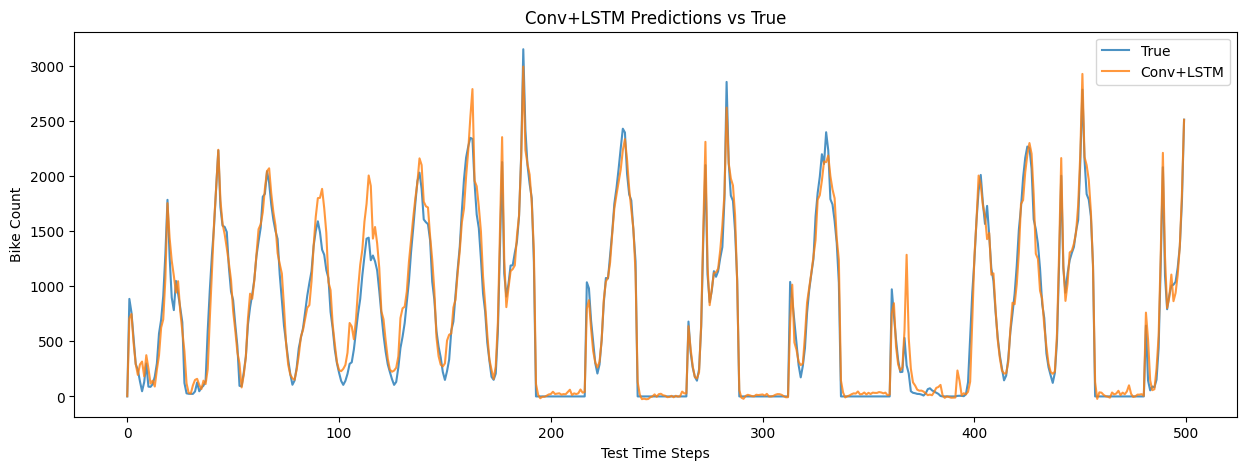

Conv+LSTM training complete!


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
        # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)
    # df['temp_humidity_interaction'] = df['Temperature(°C)'] * df['Humidity(%)']

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin','hour_cos','day_sin','day_cos','lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")

# --- 6. SIMPLIFIED & WORKING Conv + LSTM ---
class OptimizedConvLSTM(nn.Module):  # BACK TO BASELINE + MINIMAL IMPROVEMENTS
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        # BACK TO 2 LAYERS (your baseline worked)
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers,
                           batch_first=True, dropout=dropout if num_lstm_layers>1 else 0)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)
        
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]  # BACK TO h_n (worked better)
        final_h = self.dropout(final_h)
        return self.fc(final_h)

# PROVEN HYPERPARAMS FROM YOUR BEST RUN
model = OptimizedConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # BASELINE LR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTM: {n_features} feats -> 32 conv ch -> 64 LSTM hidden")
print(f"Input shape: [B, {seq_len}, {n_features}]")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    # if (epoch + 1) % 10 == 0:
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Conv+LSTM', alpha=0.8)
plt.legend()
plt.title('Conv+LSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.show()

print("Conv+LSTM training complete!")


addinf temporal attetntion

Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTM+Attn: 20 feats -> 40 conv ch -> 80 LSTM hidden + attention
Input shape: [B, 24, 20]
Epoch 1/100: Loss 0.3818
Epoch 2/100: Loss 0.2078
Epoch 3/100: Loss 0.1855
Epoch 4/100: Loss 0.1612
Epoch 5/100: Loss 0.1454
Epoch 6/100: Loss 0.1345
Epoch 7/100: Loss 0.1137
Epoch 8/100: Loss 0.0956
Epoch 9/100: Loss 0.0906
Epoch 10/100: Loss 0.0767
Epoch 11/100: Loss 0.0665
Epoch 12/100: Loss 0.0608
Epoch 13/100: Loss 0.0598
Epoch 14/100: Loss 0.0561
Epoch 15/100: Loss 0.0498
Epoch 16/100: Loss 0.0507
Epoch 17/100: Loss 0.0505
Epoch 18/100: Loss 0.0451
Epoch 19/100: Loss 0.0447
Epoch 20/100: Loss 0.0414
Epoch 21/100: Loss 0.0409
Epoch 22/100: Loss 0.0411
Epoch 23/100: Loss 0.0431
Epoch 24/100: Loss 0.0375
Epoch 25/100: Loss 0.0403
Epoch 26/100: Loss 0.0371
Epoch 27/100: Loss 0.0370
Epoch 28/100: Loss 0.0369
Epoch 29/100: Loss 0.0345
Epoch 30/100: Loss 0.0358
Epoch 31/100: Loss 0.0342
Epoch 32/100: Loss 0.0333
Epoch 33/100: Loss 0.0352
Epoch 3

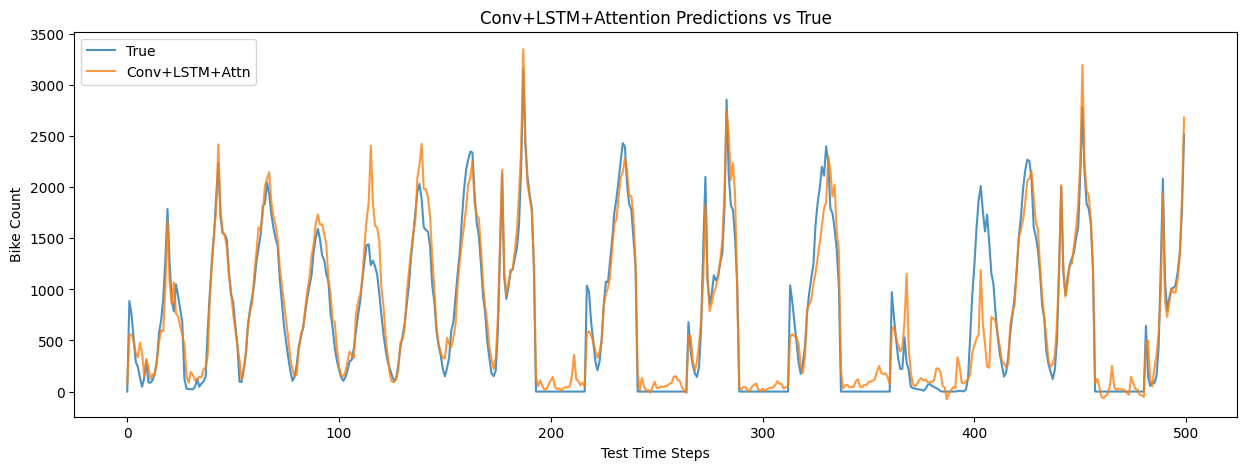

Conv+LSTM+Attention training complete!


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# XGBoost feature selection
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")

# --- 6. Conv + LSTM + Lightweight Temporal Attention ---
class OptimizedConvLSTMWithAttn(nn.Module):
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80,
                 num_lstm_layers=2, dropout=0.25, attn_dim=32):
        super().__init__()
        # Convolutional feature extractor
        self.conv1 = nn.Conv1d(input_size, conv_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, kernel_size=3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)

        # Temporal model
        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=lstm_hidden,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0.0
        )

        # Temporal attention over LSTM outputs
        self.attn = nn.Linear(lstm_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        # x: [B, T, F]
        # Conv part
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)              # [B, T, C]

        # LSTM part
        lstm_out, _ = self.lstm(x)         # [B, T, H]

        # Attention over time steps
        attn_hidden = torch.tanh(self.attn(lstm_out))      # [B, T, attn_dim]
        attn_scores = self.attn_score(attn_hidden)         # [B, T, 1]
        attn_weights = torch.softmax(attn_scores, dim=1)   # [B, T, 1]

        context = (lstm_out * attn_weights).sum(dim=1)     # [B, H]
        context = self.dropout(context)
        out = self.fc(context)                             # [B, 1]
        return out

# Instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OptimizedConvLSTMWithAttn(
    input_size=n_features,
    conv_channels=40,
    lstm_hidden=80,
    num_lstm_layers=2,
    dropout=0.25,
    attn_dim=32
)
model.to(device)

print(f"ConvLSTM+Attn: {n_features} feats -> 40 conv ch -> 80 LSTM hidden + attention")
print(f"Input shape: [B, {seq_len}, {n_features}]")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM + Attn Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Conv+LSTM+Attn', alpha=0.8)
plt.legend()
plt.title('Conv+LSTM+Attention Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.show()

print("Conv+LSTM+Attention training complete!")


adding early stopping to the above LSTM + Attention

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False  # do not stop
        else:
            self.counter += 1
            return self.counter >= self.patience  # True => stop

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (same as your code) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # cyclical encodings
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin','hour_cos','day_sin','day_cos','lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")

# --- 6. Conv + LSTM (your optimized baseline) ---
class OptimizedConvLSTM(nn.Module):
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)

        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=lstm_hidden,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)      # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)      # [B, T, C]

        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]          # [B, H]
        final_h = self.dropout(final_h)
        return self.fc(final_h)    # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OptimizedConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.25).to(device)

print(f"ConvLSTM: {n_features} feats -> 40 conv ch -> 80 LSTM hidden")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100

early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- 8. Evaluation on test set ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM with Early Stopping Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")


Training on 5934 train sequences, 1047 val sequences
ConvLSTM: 20 feats -> 40 conv ch -> 80 LSTM hidden
Epoch 1/100: train 0.2050 | val 0.1511
Epoch 2/100: train 0.0948 | val 0.1020
Epoch 3/100: train 0.0748 | val 0.1297
Epoch 4/100: train 0.0666 | val 0.0837
Epoch 5/100: train 0.0587 | val 0.0705
Epoch 6/100: train 0.0517 | val 0.0999
Epoch 7/100: train 0.0505 | val 0.0590
Epoch 8/100: train 0.0431 | val 0.0675
Epoch 9/100: train 0.0462 | val 0.0698
Epoch 10/100: train 0.0429 | val 0.0553
Epoch 11/100: train 0.0403 | val 0.0671
Epoch 12/100: train 0.0356 | val 0.0580
Epoch 13/100: train 0.0362 | val 0.0611
Epoch 14/100: train 0.0346 | val 0.0590
Epoch 15/100: train 0.0327 | val 0.0650
Epoch 16/100: train 0.0344 | val 0.0713
Epoch 17/100: train 0.0327 | val 0.0601
Epoch 18/100: train 0.0334 | val 0.0499
Epoch 19/100: train 0.0310 | val 0.0633
Epoch 20/100: train 0.0335 | val 0.0540
Epoch 21/100: train 0.0320 | val 0.0685
Epoch 22/100: train 0.0317 | val 0.0539
Epoch 23/100: train 0.032

changing LR

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False  # do not stop
        else:
            self.counter += 1
            return self.counter >= self.patience  # True => stop

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (same as your code) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # cyclical encodings
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin','hour_cos','day_sin','day_cos','lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")

# --- 6. Conv + LSTM (your optimized baseline) ---
class OptimizedConvLSTM(nn.Module):
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.40):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)

        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=lstm_hidden,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)      # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)      # [B, T, C]

        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]          # [B, H]
        final_h = self.dropout(final_h)
        return self.fc(final_h)    # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OptimizedConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.4).to(device)

print(f"ConvLSTM: {n_features} feats -> 40 conv ch -> 80 LSTM hidden")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100

early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- 8. Evaluation on test set ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM with Early Stopping Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")


Training on 5934 train sequences, 1047 val sequences
ConvLSTM: 20 feats -> 40 conv ch -> 80 LSTM hidden
Epoch 1/100: train 0.2137 | val 0.1665
Epoch 2/100: train 0.0942 | val 0.1284
Epoch 3/100: train 0.0786 | val 0.1289
Epoch 4/100: train 0.0674 | val 0.0899
Epoch 5/100: train 0.0627 | val 0.1114
Epoch 6/100: train 0.0569 | val 0.0857
Epoch 7/100: train 0.0464 | val 0.0693
Epoch 8/100: train 0.0491 | val 0.0619
Epoch 9/100: train 0.0472 | val 0.0659
Epoch 10/100: train 0.0457 | val 0.0728
Epoch 11/100: train 0.0465 | val 0.0599
Epoch 12/100: train 0.0418 | val 0.0605
Epoch 13/100: train 0.0408 | val 0.0605
Epoch 14/100: train 0.0424 | val 0.0886
Epoch 15/100: train 0.0394 | val 0.0558
Epoch 16/100: train 0.0397 | val 0.0527
Epoch 17/100: train 0.0360 | val 0.0548
Epoch 18/100: train 0.0375 | val 0.0828
Epoch 19/100: train 0.0352 | val 0.0541
Epoch 20/100: train 0.0372 | val 0.0618
Epoch 21/100: train 0.0354 | val 0.0684
Epoch 22/100: train 0.0334 | val 0.0874
Epoch 23/100: train 0.038

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False  # do not stop
        else:
            self.counter += 1
            return self.counter >= self.patience  # True => stop

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (same as your code) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # cyclical encodings
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin','hour_cos','day_sin','day_cos','lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")

# --- 6. Conv + LSTM (your optimized baseline) ---
class OptimizedConvLSTM(nn.Module):
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)

        self.lstm = nn.LSTM(
            input_size=conv_channels,
            hidden_size=lstm_hidden,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0.0
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)      # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)      # [B, T, C]

        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]          # [B, H]
        final_h = self.dropout(final_h)
        return self.fc(final_h)    # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OptimizedConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.25).to(device)

print(f"ConvLSTM: {n_features} feats -> 40 conv ch -> 80 LSTM hidden")

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100

early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- 8. Evaluation on test set ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM with Early Stopping Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")


Training on 5934 train sequences, 1047 val sequences
ConvLSTM: 20 feats -> 40 conv ch -> 80 LSTM hidden
Epoch 1/100: train 0.1787 | val 0.1320
Epoch 2/100: train 0.0837 | val 0.0974
Epoch 3/100: train 0.0691 | val 0.1047
Epoch 4/100: train 0.0613 | val 0.1136
Epoch 5/100: train 0.0540 | val 0.0737
Epoch 6/100: train 0.0505 | val 0.0882
Epoch 7/100: train 0.0451 | val 0.0966
Epoch 8/100: train 0.0447 | val 0.0729
Epoch 9/100: train 0.0454 | val 0.0512
Epoch 10/100: train 0.0457 | val 0.0744
Epoch 11/100: train 0.0419 | val 0.0547
Epoch 12/100: train 0.0407 | val 0.0742
Epoch 13/100: train 0.0399 | val 0.0629
Epoch 14/100: train 0.0359 | val 0.0497
Epoch 15/100: train 0.0360 | val 0.0582
Epoch 16/100: train 0.0376 | val 0.0532
Epoch 17/100: train 0.0344 | val 0.0522
Epoch 18/100: train 0.0357 | val 0.0492
Epoch 19/100: train 0.0338 | val 0.0737
Epoch 20/100: train 0.0334 | val 0.0510
Epoch 21/100: train 0.0340 | val 0.0552
Epoch 22/100: train 0.0335 | val 0.0470
Epoch 23/100: train 0.033

Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTM: 20 feats -> 32 conv ch -> 64 LSTM hidden
Input shape: [B, 24, 20]
Epoch 1/100: Loss 0.1941
Epoch 2/100: Loss 0.0884
Epoch 3/100: Loss 0.0679
Epoch 4/100: Loss 0.0551
Epoch 5/100: Loss 0.0490
Epoch 6/100: Loss 0.0464
Epoch 7/100: Loss 0.0461
Epoch 8/100: Loss 0.0456
Epoch 9/100: Loss 0.0415
Epoch 10/100: Loss 0.0383
Epoch 11/100: Loss 0.0364
Epoch 12/100: Loss 0.0374
Epoch 13/100: Loss 0.0394
Epoch 14/100: Loss 0.0359
Epoch 15/100: Loss 0.0343
Epoch 16/100: Loss 0.0351
Epoch 17/100: Loss 0.0320
Epoch 18/100: Loss 0.0320
Epoch 19/100: Loss 0.0332
Epoch 20/100: Loss 0.0305
Epoch 21/100: Loss 0.0327
Epoch 22/100: Loss 0.0318
Epoch 23/100: Loss 0.0303
Epoch 24/100: Loss 0.0293
Epoch 25/100: Loss 0.0298
Epoch 26/100: Loss 0.0299
Epoch 27/100: Loss 0.0289
Epoch 28/100: Loss 0.0292
Epoch 29/100: Loss 0.0297
Epoch 30/100: Loss 0.0294
Epoch 31/100: Loss 0.0276
Epoch 32/100: Loss 0.0295
Epoch 33/100: Loss 0.0286
Epoch 34/100: Loss 0.026

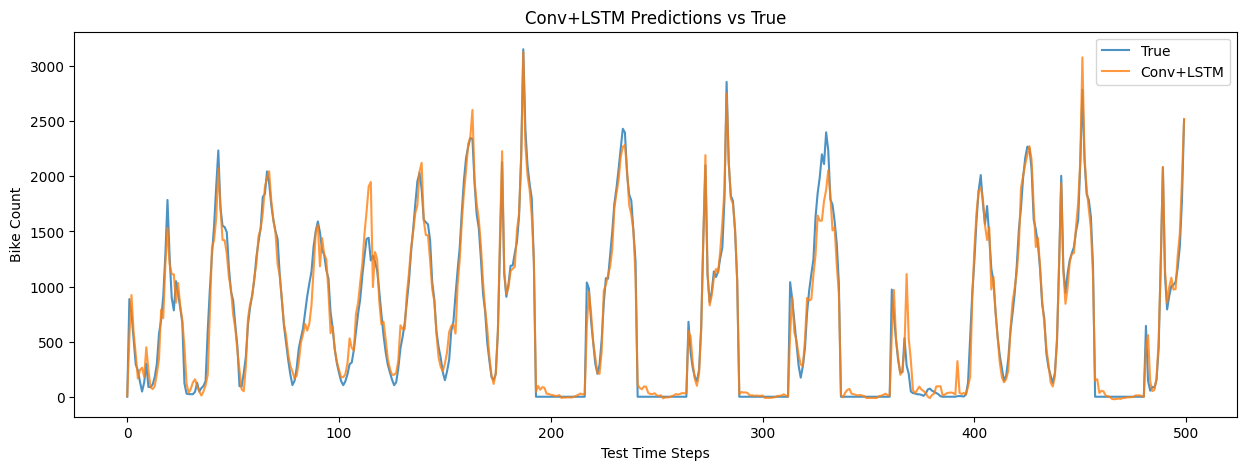

Conv+LSTM training complete!


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
        # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)
    # df['temp_humidity_interaction'] = df['Temperature(°C)'] * df['Humidity(%)']

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin','hour_cos','day_sin','day_cos','lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")

# --- 6. SIMPLIFIED & WORKING Conv + LSTM ---
class OptimizedConvLSTM(nn.Module):  # BACK TO BASELINE + MINIMAL IMPROVEMENTS
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        # BACK TO 2 LAYERS (your baseline worked)
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers,
                           batch_first=True, dropout=dropout if num_lstm_layers>1 else 0)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)
        
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]  # BACK TO h_n (worked better)
        final_h = self.dropout(final_h)
        return self.fc(final_h)

# PROVEN HYPERPARAMS FROM YOUR BEST RUN
model = OptimizedConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # BASELINE LR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTM: {n_features} feats -> 32 conv ch -> 64 LSTM hidden")
print(f"Input shape: [B, {seq_len}, {n_features}]")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    # if (epoch + 1) % 10 == 0:
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Conv+LSTM', alpha=0.8)
plt.legend()
plt.title('Conv+LSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.show()

print("Conv+LSTM training complete!")


Training on 6981 sequences (shape: (6981, 24, 20))
ConvLSTM: 20 feats -> 32 conv ch -> 64 LSTM hidden
Input shape: [B, 24, 20]
Epoch 1/100: Loss 0.1971
Epoch 2/100: Loss 0.0794
Epoch 3/100: Loss 0.0654
Epoch 4/100: Loss 0.0553
Epoch 5/100: Loss 0.0461
Epoch 6/100: Loss 0.0467
Epoch 7/100: Loss 0.0469
Epoch 8/100: Loss 0.0403
Epoch 9/100: Loss 0.0411
Epoch 10/100: Loss 0.0381
Epoch 11/100: Loss 0.0396
Epoch 12/100: Loss 0.0347
Epoch 13/100: Loss 0.0377
Epoch 14/100: Loss 0.0349
Epoch 15/100: Loss 0.0371
Epoch 16/100: Loss 0.0349
Epoch 17/100: Loss 0.0331
Epoch 18/100: Loss 0.0324
Epoch 19/100: Loss 0.0337
Epoch 20/100: Loss 0.0323
Epoch 21/100: Loss 0.0333
Epoch 22/100: Loss 0.0308
Epoch 23/100: Loss 0.0331
Epoch 24/100: Loss 0.0305
Epoch 25/100: Loss 0.0311
Epoch 26/100: Loss 0.0290
Epoch 27/100: Loss 0.0288
Epoch 28/100: Loss 0.0304
Epoch 29/100: Loss 0.0286
Epoch 30/100: Loss 0.0288
Epoch 31/100: Loss 0.0294
Epoch 32/100: Loss 0.0296
Epoch 33/100: Loss 0.0294
Epoch 34/100: Loss 0.027

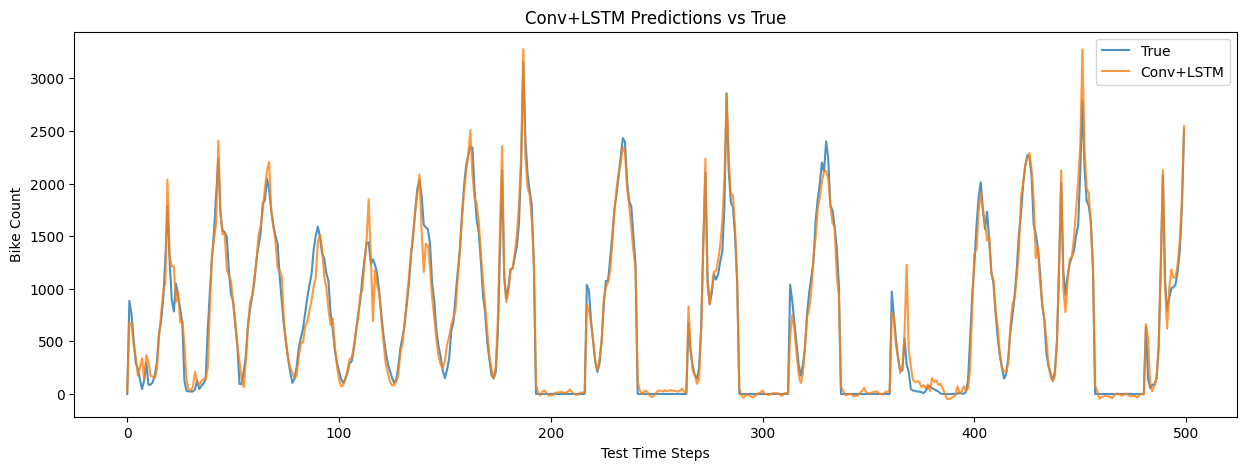

Conv+LSTM training complete!


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
        # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)
    # df['temp_humidity_interaction'] = df['Temperature(°C)'] * df['Humidity(%)']

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin','hour_cos','day_sin','day_cos','lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_train_torch = torch.from_numpy(X_train_seq)
y_train_torch = torch.from_numpy(y_train_seq).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_train_seq.shape[0]} sequences (shape: {X_train_seq.shape})")

# --- 6. SIMPLIFIED & WORKING Conv + LSTM ---
class OptimizedConvLSTM(nn.Module):  # BACK TO BASELINE + MINIMAL IMPROVEMENTS
    def __init__(self, input_size, conv_channels=40, lstm_hidden=80, num_lstm_layers=2, dropout=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, conv_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(conv_channels, conv_channels, 3, padding=1)
        self.conv_bn = nn.BatchNorm1d(conv_channels)
        
        # BACK TO 2 LAYERS (your baseline worked)
        self.lstm = nn.LSTM(conv_channels, lstm_hidden, num_layers=num_lstm_layers,
                           batch_first=True, dropout=dropout if num_lstm_layers>1 else 0)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_hidden, 1)
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        x = x.transpose(1, 2)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv_bn(x)
        x = torch.relu(x)
        x = x.transpose(1, 2)
        
        lstm_out, (h_n, c_n) = self.lstm(x)
        final_h = h_n[-1]  # BACK TO h_n (worked better)
        final_h = self.dropout(final_h)
        return self.fc(final_h)

# PROVEN HYPERPARAMS FROM YOUR BEST RUN
model = OptimizedConvLSTM(n_features, conv_channels=40, lstm_hidden=80, dropout=0.25)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # BASELINE LR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"ConvLSTM: {n_features} feats -> 32 conv ch -> 64 LSTM hidden")
print(f"Input shape: [B, {seq_len}, {n_features}]")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    # if (epoch + 1) % 10 == 0:
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 8. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) / y_true_all_orig[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all_orig - y_true_all_orig) / (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)) * 100

print("\n=== Conv + LSTM Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='Conv+LSTM', alpha=0.8)
plt.legend()
plt.title('Conv+LSTM Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.show()

print("Conv+LSTM training complete!")


TCNN max pooling

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN (max only): input 20 feats -> 80 conv channels
Epoch 1/100: train 0.4108 | val 0.2149
Epoch 2/100: train 0.1979 | val 0.1209
Epoch 3/100: train 0.1488 | val 0.0758
Epoch 4/100: train 0.1269 | val 0.0987
Epoch 5/100: train 0.1267 | val 0.0847
Epoch 6/100: train 0.1059 | val 0.1132
Epoch 7/100: train 0.1002 | val 0.0875
Epoch 8/100: train 0.0998 | val 0.0677
Epoch 9/100: train 0.0871 | val 0.0596
Epoch 10/100: train 0.0903 | val 0.0614
Epoch 11/100: train 0.0827 | val 0.0669
Epoch 12/100: train 0.0739 | val 0.0505
Epoch 13/100: train 0.0756 | val 0.0539
Epoch 14/100: train 0.0663 | val 0.0607
Epoch 15/100: train 0.0639 | val 0.0629
Epoch 16/100: train 0.0677 | val 0.0529
Epoch 17/100: train 0.0638 | val 0.0478
Epoch 18/100: train 0.0595 | val 0.0727
Epoch 19/100: train 0.0597 | val 0.0593
Epoch 20/100: train 0.0584 | val 0.0502
Epoch 21/100: train 0.0564 | val 0.0535
Epoch 22/100

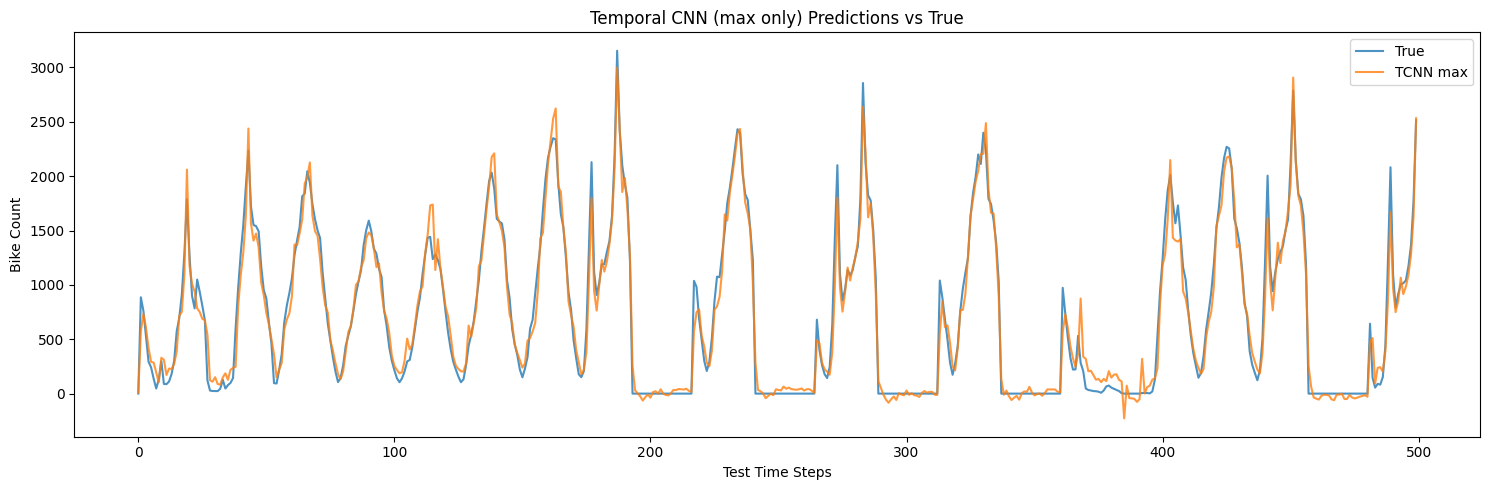

Temporal CNN (max only) training complete!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (same as before) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # cyclical encodings
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN with MAX pooling only ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)  # only max → C

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)          # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)              # [B, C, T]

        max_pool, _ = x.max(dim=2)     # [B, C]
        feats = self.dropout(max_pool)
        return self.fc(feats)          # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN (max only): input {n_features} feats -> 80 conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (max only) TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN (max only) TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN max', alpha=0.8)
plt.legend()
plt.title('Temporal CNN (max only) Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN (max only) training complete!")
